In [1]:
# in this series, we are going to build together a quant trading strategy from scratch. 

In [2]:
# lots of feedback that you would like a pratical version of my intro to quant trading video

In [3]:
# code available on github, read the readme and install the libraries

In [4]:
# 3 videos
# y_hat = model(x)
# orders = strategy(y_hat)
# execute(orders)

In [5]:
# Want part two? Please like and subscribe to let me know! And please leave a comment


In [6]:
# build a regression model to predict BTCUSD -> future log return 


# why BTCUSDT -logistic reason (Public API,Orderbook,DMA)
# clone and experiment - this is just a foundation to build upon



In [7]:
# it doesn't matter what exactly we we are trading here
# what i teach in this video is the technical and research methodology needed to build your own model for any asset
# so dont it's just only applicable for BTCUSDT

In [8]:
# this is just a foundation to build upon

In [9]:
# assumes level of programming experience
# don't worry if you don't need have programming experience
# making a machine learning series where you learn python and  machine learning at the same time.


# import all libs

In [10]:
# Data and analysis libraries
import polars as pl                         # Fast dataframes for financial data
import numpy as np                          # Numerical computing library
from datetime import datetime, timedelta    # Date and time operations
import random


# Machine learning libraries  
import torch                                # PyTorch framework
import torch.nn as nn                       # Neural network modules
import torch.optim as optim                 # Optimization algorithms
import research                             # Model building and training utilities


# Visualization and 
import altair as alt                        # Interactive visualization library

# data sources
import binance                              # Binance market data utilities


In [11]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [12]:
pl.Config.set_tbl_width_chars(200)
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(-1)  # Show all columns

polars.config.Config

# Research Parameters

In [13]:
# Trading pair symbol
sym = 'BTCUSDT'
# Historical data window in days (e.g., 6 months)            
hist_data_window = 7 * 4 * 6
# time horizon of time series (time interval)
time_interval = '1h'
# Max number of auto-regressive lags
max_lags = 4
# Forecast horizon in steps 
forecast_horizon = 1
# Sharpe annualized rate (so it's independent of time frequency)
annualized_rate = research.sharpe_annualization_factor(time_interval, 365, 24)


# download trade feeds

## Explain columns

In [14]:
binance.download_trades(sym, hist_data_window)


In [15]:
ts = research.load_ohlc_timeseries(sym,  time_interval)
ts

Loading BTCUSDT: 100%|██████████| 344/344 [00:32<00:00, 10.74file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6
…,…,…,…,…
2025-10-07 19:00:00,120838.0,122000.0,120801.6,121593.6
2025-10-07 20:00:00,121593.5,122142.6,121593.5,121885.4
2025-10-07 21:00:00,121885.4,122255.4,121710.9,121954.1


# Create Time Series

### Aggregate data into a regular time series

In [16]:
research.load_timeseries(sym, time_interval, pl.col('price').quantile(0.5).alias('price_median'))

Loading BTCUSDT: 100%|██████████| 344/344 [00:31<00:00, 10.90file/s]


datetime,price_median
datetime[μs],f64
2024-10-29 00:00:00,69848.5
2024-10-29 01:00:00,69969.0
2024-10-29 02:00:00,71180.1
2024-10-29 03:00:00,71170.5
2024-10-29 04:00:00,71029.3
…,…
2025-10-07 19:00:00,121407.1
2025-10-07 20:00:00,122004.8
2025-10-07 21:00:00,121955.1


# show static plot of time series

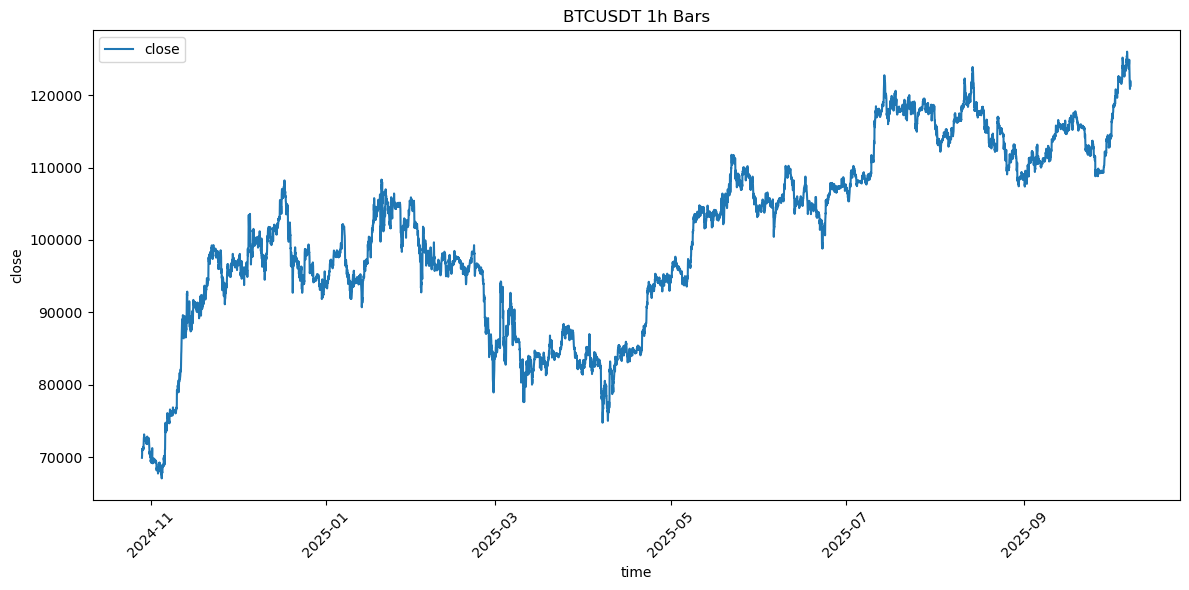

In [17]:
research.plot_static_timeseries(ts, sym, 'close', time_interval)

# dynamic interactive plot of time series

In [18]:

alt.data_transformers.enable("vegafusion")
research.plot_dyn_timeseries(ts, sym, 'close', time_interval)

alt.Chart(...)

# Feature Engineering

## Create Target - Log Return

In [19]:
price_time_series = pl.DataFrame({'price':[100.0,120.0,100.0]})
research.plot_column(price_time_series, 'price')

alt.Chart(...)

In [20]:
price_time_series = price_time_series.with_columns([
    pl.col('price').diff().alias('price_delta'),
    ((pl.col('price')-pl.col('price').shift())/pl.col('price').shift()).alias('price_return'),
    ((pl.col('price')/pl.col('price').shift())).log().alias('price_log_return'),
])
price_time_series

price,price_delta,price_return,price_log_return
f64,f64,f64,f64
100.0,null,null,null
120.0,20.0,0.2,0.182322
100.0,-20.0,-0.166667,-0.182322


## Create features and lagged features

In [21]:
ts = ts.with_columns(
    (pl.col('close') / pl.col('close').shift(forecast_horizon)).log().alias('close_log_return')
)

In [22]:
target = 'close_log_return'
lr = pl.col('close_log_return')
ts = ts.with_columns(
    lr.shift(forecast_horizon * 1).alias('close_log_return_lag_1'),
    lr.shift(forecast_horizon * 2).alias('close_log_return_lag_2'),
    lr.shift(forecast_horizon * 3).alias('close_log_return_lag_3'),
    lr.shift(forecast_horizon * 4).alias('close_log_return_lag_4'),
)
ts.select(['datetime','close_log_return','close_log_return_lag_1','close_log_return_lag_2','close_log_return_lag_3','close_log_return_lag_4'])

datetime,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64
2024-10-29 00:00:00,null,null,null,null,null
2024-10-29 01:00:00,0.004956,null,null,null,null
2024-10-29 02:00:00,0.012539,0.004956,null,null,null
2024-10-29 03:00:00,-0.003468,0.012539,0.004956,null,null
2024-10-29 04:00:00,0.001903,-0.003468,0.012539,0.004956,null
…,…,…,…,…,…
2025-10-07 19:00:00,0.006234,-0.001944,-0.004519,-0.001371,-0.007328
2025-10-07 20:00:00,0.002397,0.006234,-0.001944,-0.004519,-0.001371
2025-10-07 21:00:00,0.000563,0.002397,0.006234,-0.001944,-0.004519


In [23]:
ts = research.add_lags(ts, 'close_log_return', max_lags, forecast_horizon)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5,null,null,null,null,null
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0,0.004956,null,null,null,null
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9,0.012539,0.004956,null,null,null
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5,-0.003468,0.012539,0.004956,null,null
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6,0.001903,-0.003468,0.012539,0.004956,null
…,…,…,…,…,…,…,…,…,…
2025-10-07 19:00:00,120838.0,122000.0,120801.6,121593.6,0.006234,-0.001944,-0.004519,-0.001371,-0.007328
2025-10-07 20:00:00,121593.5,122142.6,121593.5,121885.4,0.002397,0.006234,-0.001944,-0.004519,-0.001371
2025-10-07 21:00:00,121885.4,122255.4,121710.9,121954.1,0.000563,0.002397,0.006234,-0.001944,-0.004519


In [24]:
ts.drop_nulls()

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 05:00:00,71062.5,71088.7,70880.3,71010.9,-0.000728,0.001903,-0.003468,0.012539,0.004956
2024-10-29 06:00:00,71010.8,71343.9,70983.1,71226.6,0.003033,-0.000728,0.001903,-0.003468,0.012539
2024-10-29 07:00:00,71226.6,71250.0,70803.0,71004.2,-0.003127,0.003033,-0.000728,0.001903,-0.003468
2024-10-29 08:00:00,71004.1,71208.7,70960.0,71122.1,0.001659,-0.003127,0.003033,-0.000728,0.001903
2024-10-29 09:00:00,71122.1,71332.8,71100.7,71280.0,0.002218,0.001659,-0.003127,0.003033,-0.000728
…,…,…,…,…,…,…,…,…,…
2025-10-07 19:00:00,120838.0,122000.0,120801.6,121593.6,0.006234,-0.001944,-0.004519,-0.001371,-0.007328
2025-10-07 20:00:00,121593.5,122142.6,121593.5,121885.4,0.002397,0.006234,-0.001944,-0.004519,-0.001371
2025-10-07 21:00:00,121885.4,122255.4,121710.9,121954.1,0.000563,0.002397,0.006234,-0.001944,-0.004519


In [25]:
research.plot_distribution(ts, 'close_log_return', no_bins = 100)

alt.Chart(...)

In [26]:
research.plot_distribution(ts, 'close', no_bins=100)

alt.Chart(...)

# Build Model

In [27]:
# Simple Linear Model
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)  # Single output (return prediction)
    
    def forward(self, x):
        return self.linear(x)


## Complexity

In [28]:
# Create models for comparison
input_features = 1  # Example: using 2 lag features

linear_model = LinearModel(input_features)


# Print parameter counts
research.print_model_info(linear_model, "Linear Model")
# Show the dramatic difference in complexity
research.total_model_params(linear_model)


Linear Model

Architecture:
  LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

Parameter Count:
  Total parameters:      2
  Trainable parameters:  2



2

In [29]:
# y = w * x + b

## Splitting data by time

In [30]:
ts = ts.drop_nulls()

In [31]:
# training params
features = ['close_log_return_lag_1']
target = 'close_log_return'
test_size = 0.25

In [32]:
len(ts)

8251

In [33]:
int(len(ts) * test_size)

2062

In [34]:
# Train/test timeseries split
split_idx = int(len(ts) * (1-test_size))
split_idx

6188

In [35]:
len(ts)

8251

In [36]:
ts_train, ts_test = ts[:split_idx], ts[split_idx:]

In [37]:
ts_train

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 05:00:00,71062.5,71088.7,70880.3,71010.9,-0.000728,0.001903,-0.003468,0.012539,0.004956
2024-10-29 06:00:00,71010.8,71343.9,70983.1,71226.6,0.003033,-0.000728,0.001903,-0.003468,0.012539
2024-10-29 07:00:00,71226.6,71250.0,70803.0,71004.2,-0.003127,0.003033,-0.000728,0.001903,-0.003468
2024-10-29 08:00:00,71004.1,71208.7,70960.0,71122.1,0.001659,-0.003127,0.003033,-0.000728,0.001903
2024-10-29 09:00:00,71122.1,71332.8,71100.7,71280.0,0.002218,0.001659,-0.003127,0.003033,-0.000728
…,…,…,…,…,…,…,…,…,…
2025-07-13 20:00:00,118922.9,119333.0,118771.2,119028.7,0.000888,-0.000144,0.002523,0.00147,-0.001219
2025-07-13 21:00:00,119028.7,119028.8,118411.8,118593.1,-0.003666,0.000888,-0.000144,0.002523,0.00147
2025-07-13 22:00:00,118593.0,118734.5,118197.7,118462.5,-0.001102,-0.003666,0.000888,-0.000144,0.002523


In [38]:
ts_test

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-07-14 01:00:00,119030.6,119204.5,118862.6,119052.2,0.000181,-0.000065,0.004849,-0.001102,-0.003666
2025-07-14 02:00:00,119052.2,120000.0,118930.0,119626.4,0.004812,0.000181,-0.000065,0.004849,-0.001102
2025-07-14 03:00:00,119626.4,121800.0,119558.2,120733.2,0.00921,0.004812,0.000181,-0.000065,0.004849
2025-07-14 04:00:00,120733.2,121418.2,120515.9,121370.0,0.005261,0.00921,0.004812,0.000181,-0.000065
2025-07-14 05:00:00,121370.0,122814.9,121113.3,122447.4,0.008838,0.005261,0.00921,0.004812,0.000181
…,…,…,…,…,…,…,…,…,…
2025-10-07 19:00:00,120838.0,122000.0,120801.6,121593.6,0.006234,-0.001944,-0.004519,-0.001371,-0.007328
2025-10-07 20:00:00,121593.5,122142.6,121593.5,121885.4,0.002397,0.006234,-0.001944,-0.004519,-0.001371
2025-10-07 21:00:00,121885.4,122255.4,121710.9,121954.1,0.000563,0.002397,0.006234,-0.001944,-0.004519


In [39]:
X_train = torch.tensor(ts_train[features].to_numpy(), dtype=torch.float32)
X_test = ts_test[features].to_torch().float()
y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32)
y_test = torch.tensor(ts_test[target].to_numpy(), dtype=torch.float32)

In [40]:
y_train

tensor([-7.2779e-04,  3.0330e-03, -3.1273e-03,  ..., -1.1019e-03,
         4.8488e-03, -6.4687e-05])

In [41]:
y_test

tensor([ 1.8145e-04,  4.8115e-03,  9.2096e-03,  ...,  5.6349e-04,
         2.2139e-05, -5.5114e-03])

In [42]:
y_test = y_test.reshape(-1, 1)
y_test

tensor([[ 1.8145e-04],
        [ 4.8115e-03],
        [ 9.2096e-03],
        ...,
        [ 5.6349e-04],
        [ 2.2139e-05],
        [-5.5114e-03]])

In [43]:
y_train = y_train.reshape(-1, 1)
y_train

tensor([[-7.2779e-04],
        [ 3.0330e-03],
        [-3.1273e-03],
        ...,
        [-1.1019e-03],
        [ 4.8488e-03],
        [-6.4687e-05]])

In [44]:
research.timeseries_train_test_split(ts, features, target, test_size)

(tensor([[ 0.0019],
         [-0.0007],
         [ 0.0030],
         ...,
         [-0.0037],
         [-0.0011],
         [ 0.0048]]),
 tensor([[-6.4687e-05],
         [ 1.8145e-04],
         [ 4.8115e-03],
         ...,
         [ 2.3969e-03],
         [ 5.6349e-04],
         [ 2.2139e-05]]),
 tensor([[-7.2779e-04],
         [ 3.0330e-03],
         [-3.1273e-03],
         ...,
         [-1.1019e-03],
         [ 4.8488e-03],
         [-6.4687e-05]]),
 tensor([[ 1.8145e-04],
         [ 4.8115e-03],
         [ 9.2096e-03],
         ...,
         [ 5.6349e-04],
         [ 2.2139e-05],
         [-5.5114e-03]]))

In [45]:
# Training: X_train -> model -> y_train
# Testing: X_test -> model -> y_test

In [46]:
X_train

tensor([[ 0.0019],
        [-0.0007],
        [ 0.0030],
        ...,
        [-0.0037],
        [-0.0011],
        [ 0.0048]])

In [47]:
X_train.shape

torch.Size([6188, 1])

In [48]:
y_train

tensor([[-7.2779e-04],
        [ 3.0330e-03],
        [-3.1273e-03],
        ...,
        [-1.1019e-03],
        [ 4.8488e-03],
        [-6.4687e-05]])

In [49]:
y_train = y_train.reshape(-1, 1)
y_train

tensor([[-7.2779e-04],
        [ 3.0330e-03],
        [-3.1273e-03],
        ...,
        [-1.1019e-03],
        [ 4.8488e-03],
        [-6.4687e-05]])

In [50]:
y_train.shape

torch.Size([6188, 1])

In [51]:
y_test = y_test.reshape(-1, 1)
y_test

tensor([[ 1.8145e-04],
        [ 4.8115e-03],
        [ 9.2096e-03],
        ...,
        [ 5.6349e-04],
        [ 2.2139e-05],
        [-5.5114e-03]])

In [52]:
y_test.shape

torch.Size([2063, 1])

In [53]:
X_train,X_test,y_train,y_test = research.timeseries_train_test_split(ts, features, target, test_size)

### Batch Gradient Descent

In [54]:
# Hyperparamters
no_epochs = 1000 * 5
lr = 0.0005

# create model (Kaiming uniform)
model = LinearModel(len(features))
# loss function
criterion = nn.MSELoss()
# optimization algo
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training
print("\nTraining model...")

# main learning loop
for epoch in range(no_epochs):
    # Forward pass
    y_hat = model(X_train)
    loss = criterion(y_hat, y_train)

    # Backward pass
    optimizer.zero_grad()   # 1. clear old gradients
    loss.backward()         # 2. compute new gradients
    optimizer.step()        # 3. update weights

    # Check for improvement
    train_loss = loss.item()

    # Logging
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{no_epochs}], Loss: {loss.item():.6f}")


# After training
print("\nLearned parameters:")

# print out our learned params
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}:\n{param.data.numpy()}")

# Evaluation
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_loss = criterion(y_hat, y_test)
    print(f'\nTest Loss: {test_loss.item():.6f}, Train Loss: {train_loss:.6f}')


Training model...
Epoch [500/5000], Loss: 0.468822
Epoch [1000/5000], Loss: 0.234595
Epoch [1500/5000], Loss: 0.101730
Epoch [2000/5000], Loss: 0.036156
Epoch [2500/5000], Loss: 0.009767
Epoch [3000/5000], Loss: 0.001831
Epoch [3500/5000], Loss: 0.000232
Epoch [4000/5000], Loss: 0.000041
Epoch [4500/5000], Loss: 0.000029
Epoch [5000/5000], Loss: 0.000028

Learned parameters:
linear.weight:
[[-0.06024186]]
linear.bias:
[0.00013757]

Test Loss: 0.000011, Train Loss: 0.000028


## Test trading performance

In [55]:

trade_results = pl.DataFrame({
    'y_hat':y_hat.squeeze(),
    'y':y_test.squeeze()}
).with_columns(
    (pl.col('y_hat').sign()==pl.col('y').sign()).alias('is_won'),
    pl.col('y_hat').sign().alias('signal')
).with_columns((pl.col('signal')*pl.col('y')).alias('trade_log_return')
).with_columns(
    pl.col('trade_log_return').cum_sum().alias('equity_curve')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve
f32,f32,bool,f32,f32,f32
0.000141,0.000181,true,1.0,0.000181,0.000181
0.000127,0.004812,true,1.0,0.004812,0.004993
-0.000152,0.00921,false,-1.0,-0.00921,-0.004217
-0.000417,0.005261,false,-1.0,-0.005261,-0.009477
-0.000179,0.008838,false,-1.0,-0.008838,-0.018315
…,…,…,…,…,…
0.000255,0.006234,true,1.0,0.006234,0.011934
-0.000238,0.002397,false,-1.0,-0.002397,0.009537
-0.000007,0.000563,false,-1.0,-0.000563,0.008973


In [56]:
research.plot_column(trade_results, 'equity_curve')

alt.Chart(...)

In [57]:
trade_results = trade_results.with_columns(
    (pl.col('equity_curve')-pl.col('equity_curve').cum_max()).alias('drawdown_log'),
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
0.000141,0.000181,true,1.0,0.000181,0.000181,0.0
0.000127,0.004812,true,1.0,0.004812,0.004993,0.0
-0.000152,0.00921,false,-1.0,-0.00921,-0.004217,-0.00921
-0.000417,0.005261,false,-1.0,-0.005261,-0.009477,-0.01447
-0.000179,0.008838,false,-1.0,-0.008838,-0.018315,-0.023308
…,…,…,…,…,…,…
0.000255,0.006234,true,1.0,0.006234,0.011934,-0.057448
-0.000238,0.002397,false,-1.0,-0.002397,0.009537,-0.059844
-0.000007,0.000563,false,-1.0,-0.000563,0.008973,-0.060408


In [58]:
max_drawdown_log = trade_results['drawdown_log'].min()
max_drawdown_log

-0.12351919710636139

In [59]:
drawdown_pct = np.exp(max_drawdown_log) - 1
drawdown_pct

np.float64(-0.11619532541111721)

In [60]:
equity_peak = 1000 
equity_peak * drawdown_pct 

np.float64(-116.19532541111721)

In [61]:
win_rate = trade_results['is_won'].mean()
win_rate

0.49878817256422686

In [62]:
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
0.000141,0.000181,true,1.0,0.000181,0.000181,0.0
0.000127,0.004812,true,1.0,0.004812,0.004993,0.0
-0.000152,0.00921,false,-1.0,-0.00921,-0.004217,-0.00921
-0.000417,0.005261,false,-1.0,-0.005261,-0.009477,-0.01447
-0.000179,0.008838,false,-1.0,-0.008838,-0.018315,-0.023308
…,…,…,…,…,…,…
0.000255,0.006234,true,1.0,0.006234,0.011934,-0.057448
-0.000238,0.002397,false,-1.0,-0.002397,0.009537,-0.059844
-0.000007,0.000563,false,-1.0,-0.000563,0.008973,-0.060408


In [63]:
avg_win = trade_results.filter(pl.col('is_won')==True)['trade_log_return'].mean()
avg_loss = trade_results.filter(pl.col('is_won')==False)['trade_log_return'].mean()
ev = win_rate * avg_win + (1 - win_rate) * avg_loss 
ev

1.6888728350597775e-06

In [64]:
total_log_return = trade_results['trade_log_return'].sum()
total_log_return

0.0034841597080230713

In [65]:
compound_return = np.exp(total_log_return)
compound_return

np.float64(1.003490236447853)

In [66]:
1000*compound_return

np.float64(1003.490236447853)

In [67]:
equity_trough = trade_results['equity_curve'].min()
equity_trough

-0.05982227250933647

In [68]:
equity_peak = trade_results['equity_curve'].max()

In [69]:
# not measuring risk here - best here is risk-adjsuted returns

In [70]:
std = trade_results['trade_log_return'].std()
std

0.003294288879260421

In [71]:
std_trade_log_return = trade_results['trade_log_return'].std()
sharpe = ev / std_trade_log_return * annualized_rate # sqrt of no trading periods
sharpe

np.float64(0.047982991787131064)

In [72]:
research.eval_model_performance(y_test, y_hat, features, target, annualized_rate)

{'features': 'close_log_return_lag_1',
 'target': 'close_log_return',
 'no_trades': 2063,
 'win_rate': 0.49878817256422686,
 'avg_win': 0.0022568332308331336,
 'avg_loss': -0.002242550531787782,
 'best_trade': 0.02901790291070938,
 'worst_trade': -0.02237566001713276,
 'ev': 1.6888728350597775e-06,
 'std': 0.003294288879260421,
 'total_log_return': 0.0034841597080230713,
 'compound_return': np.float64(1.003490236447853),
 'max_drawdown': -0.12351919710636139,
 'equity_trough': -0.05982227250933647,
 'equity_peak': 0.06938125193119049,
 'sharpe': np.float64(0.04798299178712566)}

In [73]:
# research.eval_model_performance(y_test, y_hat, feature_cols, target_col, annulized_rate)

In [74]:
target = 'close_log_return'
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
model.apply(research.init_weights)
perf = research.benchmark_reg_model(ts, features, target, model, annualized_rate, no_epochs=50)
perf

{'features': 'close_log_return_lag_2',
 'target': 'close_log_return',
 'no_trades': 2063,
 'win_rate': 0.5206010664081435,
 'avg_win': 0.002234703615516542,
 'avg_loss': -0.0022659322157038376,
 'best_trade': 0.02901790291070938,
 'worst_trade': -0.019244860857725143,
 'ev': 7.71035975441934e-05,
 'std': 0.0032933864276856184,
 'total_log_return': 0.15906472504138947,
 'compound_return': np.float64(1.172413828758548),
 'max_drawdown': -0.18633675575256348,
 'equity_trough': -0.04641946405172348,
 'equity_peak': 0.2001451551914215,
 'sharpe': np.float64(2.191210012762183),
 'weights': '[-0.02820785]',
 'biases': '8.019666711334139e-05'}

In [75]:
import itertools


target = 'close_log_return'
benchmarks = []
feature_pool = [f'{target}_lag_{i}' for i in range(1, max_lags + 1)]
combos = list(itertools.combinations(feature_pool, 1))
# combos += list(itertools.combinations(feature_pool, 2))
for features in combos:
    model = LinearModel(len(features))
    model.apply(research.init_weights)
    benchmarks.append(research.benchmark_reg_model(ts, list(features), target, model, annualized_rate, no_epochs=200, loss=nn.L1Loss()))

benchmark = pl.DataFrame(benchmarks)
benchmark.sort('sharpe', descending=True)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_2""","""close_log_return""",2063,0.520601,0.002235,-0.002266,0.029018,-0.019245,0.000077,0.003293,0.159065,1.172414,-0.186337,-0.046419,0.200145,2.19121,"""[-0.02820785]""","""8.019666711334139e-05"""
"""close_log_return_lag_4""","""close_log_return""",2063,0.498788,0.002264,-0.002235,0.029018,-0.022376,0.000009,0.003294,0.018775,1.018952,-0.142968,-0.103107,0.05679,0.258566,"""[-0.00203188]""","""7.858540629968047e-05"""
"""close_log_return_lag_1""","""close_log_return""",2063,0.49588,0.002274,-0.002226,0.029018,-0.022376,0.000006,0.003294,0.011769,1.011838,-0.17822,-0.046639,0.186769,0.162076,"""[-0.07202696]""","""9.449938079342246e-05"""
"""close_log_return_lag_3""","""close_log_return""",2063,0.496365,0.002271,-0.002228,0.029018,-0.022376,0.000005,0.003294,0.010284,1.010337,-0.249187,-0.224639,0.034885,0.141632,"""[-0.03211932]""","""8.902350236894563e-05"""


In [76]:
research.auto_reg_corr_matrx(ts, 'close_log_return', max_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
f64,f64,f64,f64,f64
1.0,-0.01993,0.003398,-0.022797,0.007221
-0.01993,1.0,-0.019965,0.003527,-0.022687
0.003398,-0.019965,1.0,-0.020179,0.00344
-0.022797,0.003527,-0.020179,1.0,-0.019869
0.007221,-0.022687,0.00344,-0.019869,1.0


In [77]:
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
model.apply(research.init_weights)
model_trades = research.learn_model_trades(ts, features, target, model, no_epochs=200, loss=nn.L1Loss())

research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [78]:
maker_fee = 0.0001
taker_fee = 0.0003
roundtrip_fee_log = np.log(1 - 2 * taker_fee)  # ≈ -0.001501

model_trades = model_trades.with_columns(pl.lit(roundtrip_fee_log).alias("tx_fee_log"))
model_trades = model_trades.with_columns((pl.col("trade_log_return") + pl.col("tx_fee_log")).alias("trade_log_return_net"))
model_trades = model_trades.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net'))
model_trades


y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64
-0.000057,0.000181,false,-1.0,-0.000181,-0.000181,0.0,-0.0006,-0.000782,-0.000782
0.000082,0.004812,true,1.0,0.004812,0.00463,0.0,-0.0006,0.004211,0.00343
0.000075,0.00921,true,1.0,0.00921,0.01384,0.0,-0.0006,0.008609,0.012039
-0.000056,0.005261,false,-1.0,-0.005261,0.008579,-0.005261,-0.0006,-0.005861,0.006178
-0.00018,0.008838,false,-1.0,-0.008838,-0.000259,-0.014098,-0.0006,-0.009438,-0.00326
…,…,…,…,…,…,…,…,…,…
0.000208,0.006234,true,1.0,0.006234,0.162721,-0.037425,-0.0006,0.005633,-1.07305
0.000135,0.002397,true,1.0,0.002397,0.165117,-0.035028,-0.0006,0.001797,-1.071254
-0.000096,0.000563,false,-1.0,-0.000563,0.164554,-0.035591,-0.0006,-0.001164,-1.072417


In [79]:
research.plot_column(model_trades, 'equity_curve_net')

alt.Chart(...)

In [80]:
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [81]:
model_trades['is_won'].mean()

0.5206010664081435

In [82]:
model_trades['trade_log_return'].mean()

7.710359754419338e-05

In [83]:
model_trades = research.add_tx_fees(model_trades, maker_fee, taker_fee)
model_trades

y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net,tx_fee_log_maker,trade_log_return_net_maker,equity_curve_net_maker,tx_fee_log_taker,trade_log_return_net_taker,equity_curve_net_taker
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.000057,0.000181,false,-1.0,-0.000181,-0.000181,0.0,-0.0006,-0.000782,-0.000782,-0.0002,-0.000381,-0.000381,-0.0006,-0.000782,-0.000782
0.000082,0.004812,true,1.0,0.004812,0.00463,0.0,-0.0006,0.004211,0.00343,-0.0002,0.004611,0.00423,-0.0006,0.004211,0.00343
0.000075,0.00921,true,1.0,0.00921,0.01384,0.0,-0.0006,0.008609,0.012039,-0.0002,0.00901,0.01324,-0.0006,0.008609,0.012039
-0.000056,0.005261,false,-1.0,-0.005261,0.008579,-0.005261,-0.0006,-0.005861,0.006178,-0.0002,-0.005461,0.007779,-0.0006,-0.005861,0.006178
-0.00018,0.008838,false,-1.0,-0.008838,-0.000259,-0.014098,-0.0006,-0.009438,-0.00326,-0.0002,-0.009038,-0.001259,-0.0006,-0.009438,-0.00326
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.000208,0.006234,true,1.0,0.006234,0.162721,-0.037425,-0.0006,0.005633,-1.07305,-0.0002,0.006034,-0.249121,-0.0006,0.005633,-1.07305
0.000135,0.002397,true,1.0,0.002397,0.165117,-0.035028,-0.0006,0.001797,-1.071254,-0.0002,0.002197,-0.246924,-0.0006,0.001797,-1.071254
-0.000096,0.000563,false,-1.0,-0.000563,0.164554,-0.035591,-0.0006,-0.001164,-1.072417,-0.0002,-0.000764,-0.247687,-0.0006,-0.001164,-1.072417


In [84]:
research.plot_column(model_trades, 'equity_curve_net_maker')

alt.Chart(...)

## Model for Net Returns

In [85]:
# 6h
time_interval = '8h'
ts = research.load_ohlc_timeseries(sym, time_interval)
ts

Loading BTCUSDT: 100%|██████████| 344/344 [00:30<00:00, 11.16file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8
…,…,…,…,…
2025-10-06 08:00:00,123332.4,125375.0,123332.3,124946.2
2025-10-06 16:00:00,124946.2,126208.5,124463.0,124628.5
2025-10-07 00:00:00,124628.6,125047.0,123503.9,123627.1


In [86]:
no_lags = 3
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=no_lags)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2,null,null,null,null
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9,0.019121,null,null,null
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5,0.005025,0.019121,null,null
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8,-0.006824,0.005025,0.019121,null
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8,-0.002578,-0.006824,0.005025,0.019121
…,…,…,…,…,…,…,…,…
2025-10-06 08:00:00,123332.4,125375.0,123332.3,124946.2,0.013001,-0.000765,0.005473,-0.015676
2025-10-06 16:00:00,124946.2,126208.5,124463.0,124628.5,-0.002546,0.013001,-0.000765,0.005473
2025-10-07 00:00:00,124628.6,125047.0,123503.9,123627.1,-0.008068,-0.002546,0.013001,-0.000765


In [87]:
target = 'close_log_return'
feature_pool = [f'{target}_lag_{i}' for i in range(1, no_lags + 1)]
research.benchmark_linear_models(ts.drop_nulls(), 'close_log_return', feature_pool, annualized_rate, loss=nn.HuberLoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_3""","""close_log_return""",257,0.540856,0.006644,-0.006988,0.028596,-0.029649,0.000385,0.009207,0.098942,1.104002,-0.101469,-0.046606,0.12867,3.913587,"""[-0.05471822]""","""0.0007264153682626784"""
"""close_log_return_lag_2""","""close_log_return""",257,0.536965,0.006365,-0.007308,0.028596,-0.029649,0.000034,0.009215,0.008702,1.00874,-0.111369,-0.105772,0.03843,0.343909,"""[-0.03405796]""","""0.0007108924328349531"""
"""close_log_return_lag_1""","""close_log_return""",257,0.525292,0.006494,-0.007142,0.028596,-0.029649,0.000021,0.009215,0.005424,1.005439,-0.140672,-0.088564,0.052109,0.214364,"""[-0.02933751]""","""0.000707677158061415"""


In [88]:
research.auto_reg_corr_matrx(ts.drop_nulls(), target, no_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
f64,f64,f64,f64
1.0,-0.032434,-0.036599,-0.059256
-0.032434,1.0,-0.033026,-0.037533
-0.036599,-0.033026,1.0,-0.033292
-0.059256,-0.037533,-0.033292,1.0


In [89]:
research.benchmark_linear_models(ts.drop_nulls(), 'close_log_return', feature_pool, annualized_rate, loss=nn.MSELoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_3""","""close_log_return""",257,0.540856,0.006644,-0.006988,0.028596,-0.029649,0.000385,0.009207,0.098942,1.104002,-0.101469,-0.046606,0.12867,3.913587,"""[-0.05510984]""","""0.0007302482263185084"""
"""close_log_return_lag_2""","""close_log_return""",257,0.536965,0.006365,-0.007308,0.028596,-0.029649,0.000034,0.009215,0.008702,1.00874,-0.111369,-0.105772,0.03843,0.343909,"""[-0.03455307]""","""0.0007160435197874904"""
"""close_log_return_lag_1""","""close_log_return""",257,0.525292,0.006494,-0.007142,0.028596,-0.029649,0.000021,0.009215,0.005424,1.005439,-0.140672,-0.088564,0.052109,0.214364,"""[-0.02983443]""","""0.0007129147415980697"""


In [90]:
research.benchmark_linear_models(ts.drop_nulls(), 'close_log_return', feature_pool, annualized_rate, loss=nn.L1Loss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",257,0.568093,0.00654,-0.007146,0.028596,-0.029649,0.000629,0.009194,0.161562,1.175346,-0.116449,-0.01561,0.188744,6.399872,"""[-0.04842816]""","""0.000314566568704322"""
"""close_log_return_lag_2""","""close_log_return""",257,0.529183,0.006738,-0.006874,0.029649,-0.025694,0.000329,0.009209,0.084615,1.088298,-0.125134,-0.081818,0.157923,3.346117,"""[-0.05754738]""","""0.00031285849399864674"""
"""close_log_return_lag_3""","""close_log_return""",257,0.529183,0.006383,-0.007272,0.028596,-0.029649,-0.000046,0.009215,-0.011839,0.98823,-0.130755,-0.125936,0.017888,-0.467898,"""[-0.00114836]""","""0.00043495764839462936"""


In [91]:

# experiment with different hyperparameters,
# different loss functions, different optimizers

In [92]:
features = ['close_log_return_lag_1']
model = LinearModel(len(features))
model.apply(research.init_weights)
model_trades = research.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.L1Loss())
model_trades = research.add_tx_fees(model_trades, maker_fee, taker_fee)
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [93]:
research.plot_column(model_trades, 'equity_curve_net_taker')

alt.Chart(...)

In [94]:
torch.save(model.state_dict(), 'model_weights.pth')

In [95]:
# how to use a modern machine learning library - pytorch
# dont focus on the win rate - Either you have a high win rate OR you're a bad trader
# measure AS MUCH AS POSSIBLE
# this is just a foundation to build upon: 
    # increase the model complexity, 
    # create new features
    # use a rolling window to train models

# next video is we are going to build a strategy around this model

# please like and subscribe as this is the only feedback signal i have if you want more content

In [96]:
# 1. Entry/exit timing
# 2. position size
# 3. should we use take-profit orders?
# 4. should we use stop-loss orders?

# the key metric is we want to increase the expected value of our trade?

In [257]:
ts = research.load_ohlc_timeseries(sym, '8h')
ts

Loading BTCUSDT: 100%|██████████| 344/344 [00:35<00:00,  9.71file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8
…,…,…,…,…
2025-10-06 08:00:00,123332.4,125375.0,123332.3,124946.2
2025-10-06 16:00:00,124946.2,126208.5,124463.0,124628.5
2025-10-07 00:00:00,124628.6,125047.0,123503.9,123627.1


In [264]:
forecast_horizon

1

In [265]:
max_lags

4

In [266]:
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=1)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1
datetime[μs],f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2,null,null
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9,0.019121,null
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5,0.005025,0.019121
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8,-0.006824,0.005025
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8,-0.002578,-0.006824
…,…,…,…,…,…,…
2025-10-06 08:00:00,123332.4,125375.0,123332.3,124946.2,0.013001,-0.000765
2025-10-06 16:00:00,124946.2,126208.5,124463.0,124628.5,-0.002546,0.013001
2025-10-07 00:00:00,124628.6,125047.0,123503.9,123627.1,-0.008068,-0.002546


In [267]:
train_trades, test_trades = research.timeseries_split(ts, test_size)
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1
datetime[μs],f64,f64,f64,f64,f64,f64
2025-07-14 00:00:00,119038.3,123300.0,118862.6,122731.0,0.03055,0.003599
2025-07-14 08:00:00,122731.0,122772.7,119590.9,119863.1,-0.023645,0.03055
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694
…,…,…,…,…,…,…
2025-10-06 08:00:00,123332.4,125375.0,123332.3,124946.2,0.013001,-0.000765
2025-10-06 16:00:00,124946.2,126208.5,124463.0,124628.5,-0.002546,0.013001
2025-10-07 00:00:00,124628.6,125047.0,123503.9,123627.1,-0.008068,-0.002546


In [268]:
import models
model = models.LinearModel(1)
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [269]:
research.print_model_parms(model)

linear.weight:
[[-0.04842816]]
linear.bias:
[0.00031457]


## Timing

In [270]:
# 00:00 -> trade to create a BTCUSDT position based on our prediction
# 08:00 -> trade to close the existing BTCUSDT position, trade to enter a new position on the current log return (00:00 -> 08:00) prediction
# 16:00 -> trade to close the existing BTCUSDT pos, trade to enter a new position on the current log return (08:00 -> 16:00) prediction

In [271]:
X_train, X_test, y_train, y_test = research.timeseries_train_test_split(ts, ['close_log_return_lag_1'], 'close_log_return', test_size)

In [272]:
y_hat = model(X_test)


In [273]:
y_hat = y_hat.detach().numpy()
y_hat

array([[ 1.40252727e-04],
       [-1.16489816e-03],
       [ 1.45963638e-03],
       [ 3.33397969e-04],
       [ 1.55889988e-03],
       [ 4.74117667e-04],
       [-2.42050606e-04],
       [ 1.32816844e-04],
       [-4.25877479e-05],
       [ 5.04206517e-04],
       [ 4.35920898e-04],
       [ 7.72533385e-05],
       [ 1.91854182e-04],
       [ 2.41477625e-04],
       [ 9.37969831e-04],
       [ 2.87283852e-04],
       [ 2.16656190e-04],
       [ 3.59434693e-04],
       [ 4.01303609e-04],
       [ 2.44778697e-04],
       [ 3.42126586e-05],
       [ 9.11310257e-04],
       [-5.60065324e-04],
       [ 7.41720258e-04],
       [ 7.14885653e-04],
       [ 5.55164515e-05],
       [-6.99421871e-05],
       [-1.28944303e-04],
       [ 9.91943991e-04],
       [ 2.31146565e-04],
       [ 2.40059962e-04],
       [ 4.55715839e-04],
       [ 2.65365743e-05],
       [ 6.32759009e-04],
       [ 1.56087987e-03],
       [ 1.47419632e-04],
       [-4.72729706e-04],
       [ 4.36383649e-04],
       [-2.4

In [274]:
y_hat = y_hat.squeeze()
y_hat

array([ 1.40252727e-04, -1.16489816e-03,  1.45963638e-03,  3.33397969e-04,
        1.55889988e-03,  4.74117667e-04, -2.42050606e-04,  1.32816844e-04,
       -4.25877479e-05,  5.04206517e-04,  4.35920898e-04,  7.72533385e-05,
        1.91854182e-04,  2.41477625e-04,  9.37969831e-04,  2.87283852e-04,
        2.16656190e-04,  3.59434693e-04,  4.01303609e-04,  2.44778697e-04,
        3.42126586e-05,  9.11310257e-04, -5.60065324e-04,  7.41720258e-04,
        7.14885653e-04,  5.55164515e-05, -6.99421871e-05, -1.28944303e-04,
        9.91943991e-04,  2.31146565e-04,  2.40059962e-04,  4.55715839e-04,
        2.65365743e-05,  6.32759009e-04,  1.56087987e-03,  1.47419632e-04,
       -4.72729706e-04,  4.36383649e-04, -2.40627705e-05,  4.05636034e-04,
        2.34774008e-04,  1.11084191e-04, -2.83327336e-05,  5.38197288e-04,
        6.08945673e-04,  3.60248436e-04, -1.85682584e-05,  9.33966599e-04,
        8.75797705e-05,  2.38183158e-04,  3.69184243e-04,  3.88116576e-04,
       -3.49689435e-05,  

In [275]:
test_trades = test_trades.with_columns(pl.Series('prediction', y_hat))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction
datetime[μs],f64,f64,f64,f64,f64,f64,f32
2025-07-14 00:00:00,119038.3,123300.0,118862.6,122731.0,0.03055,0.003599,0.00014
2025-07-14 08:00:00,122731.0,122772.7,119590.9,119863.1,-0.023645,0.03055,-0.001165
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.00146
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000333
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.001559
…,…,…,…,…,…,…,…
2025-10-06 08:00:00,123332.4,125375.0,123332.3,124946.2,0.013001,-0.000765,0.000352
2025-10-06 16:00:00,124946.2,126208.5,124463.0,124628.5,-0.002546,0.013001,-0.000315
2025-10-07 00:00:00,124628.6,125047.0,123503.9,123627.1,-0.008068,-0.002546,0.000438


In [276]:
0.003599 * -0.04842816 

-0.00017429294784

In [277]:
0.003599 * -0.04842816 + 0.00031457 

0.00014027705216000002

## directional signal

In [278]:
test_trades = test_trades.with_columns(pl.col('prediction').sign().alias('dir_signal'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32
2025-07-14 00:00:00,119038.3,123300.0,118862.6,122731.0,0.03055,0.003599,0.00014,1.0
2025-07-14 08:00:00,122731.0,122772.7,119590.9,119863.1,-0.023645,0.03055,-0.001165,-1.0
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.00146,1.0
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000333,1.0
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.001559,1.0
…,…,…,…,…,…,…,…,…
2025-10-06 08:00:00,123332.4,125375.0,123332.3,124946.2,0.013001,-0.000765,0.000352,1.0
2025-10-06 16:00:00,124946.2,126208.5,124463.0,124628.5,-0.002546,0.013001,-0.000315,-1.0
2025-10-07 00:00:00,124628.6,125047.0,123503.9,123627.1,-0.008068,-0.002546,0.000438,1.0


## constant trade size

In [279]:
trade_size = 100
test_trades = test_trades.with_columns(pl.lit(trade_size).alias('trade_size'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_size
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,i32
2025-07-14 00:00:00,119038.3,123300.0,118862.6,122731.0,0.03055,0.003599,0.00014,1.0,100
2025-07-14 08:00:00,122731.0,122772.7,119590.9,119863.1,-0.023645,0.03055,-0.001165,-1.0,100
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.00146,1.0,100
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000333,1.0,100
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.001559,1.0,100
…,…,…,…,…,…,…,…,…,…
2025-10-06 08:00:00,123332.4,125375.0,123332.3,124946.2,0.013001,-0.000765,0.000352,1.0,100
2025-10-06 16:00:00,124946.2,126208.5,124463.0,124628.5,-0.002546,0.013001,-0.000315,-1.0,100
2025-10-07 00:00:00,124628.6,125047.0,123503.9,123627.1,-0.008068,-0.002546,0.000438,1.0,100


In [280]:
test_trades = test_trades.with_columns((pl.col('dir_signal')*pl.col('close_log_return')).alias('trade_log_return'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_size,trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,i32,f64
2025-07-14 00:00:00,119038.3,123300.0,118862.6,122731.0,0.03055,0.003599,0.00014,1.0,100,0.03055
2025-07-14 08:00:00,122731.0,122772.7,119590.9,119863.1,-0.023645,0.03055,-0.001165,-1.0,100,0.023645
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.00146,1.0,100,-0.000389
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000333,1.0,100,-0.025694
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.001559,1.0,100,-0.003295
…,…,…,…,…,…,…,…,…,…,…
2025-10-06 08:00:00,123332.4,125375.0,123332.3,124946.2,0.013001,-0.000765,0.000352,1.0,100,0.013001
2025-10-06 16:00:00,124946.2,126208.5,124463.0,124628.5,-0.002546,0.013001,-0.000315,-1.0,100,0.002546
2025-10-07 00:00:00,124628.6,125047.0,123503.9,123627.1,-0.008068,-0.002546,0.000438,1.0,100,-0.008068


In [281]:
test_trades = test_trades.with_columns(((pl.col('trade_log_return').exp() - 1) * pl.col('trade_size')).alias('trade_gross_pnl'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_size,trade_log_return,trade_gross_pnl
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,i32,f64,f64
2025-07-14 00:00:00,119038.3,123300.0,118862.6,122731.0,0.03055,0.003599,0.00014,1.0,100,0.03055,3.102111
2025-07-14 08:00:00,122731.0,122772.7,119590.9,119863.1,-0.023645,0.03055,-0.001165,-1.0,100,0.023645,2.392646
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.00146,1.0,100,-0.000389,-0.038878
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000333,1.0,100,-0.025694,-2.536712
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.001559,1.0,100,-0.003295,-0.328917
…,…,…,…,…,…,…,…,…,…,…,…
2025-10-06 08:00:00,123332.4,125375.0,123332.3,124946.2,0.013001,-0.000765,0.000352,1.0,100,0.013001,1.308579
2025-10-06 16:00:00,124946.2,126208.5,124463.0,124628.5,-0.002546,0.013001,-0.000315,-1.0,100,0.002546,0.254918
2025-10-07 00:00:00,124628.6,125047.0,123503.9,123627.1,-0.008068,-0.002546,0.000438,1.0,100,-0.008068,-0.803508


In [282]:
test_trades = test_trades.with_columns(((pl.col('trade_log_return').exp()) * pl.col('trade_size')).alias('trade_value'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_size,trade_log_return,trade_gross_pnl,trade_value
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,i32,f64,f64,f64
2025-07-14 00:00:00,119038.3,123300.0,118862.6,122731.0,0.03055,0.003599,0.00014,1.0,100,0.03055,3.102111,103.102111
2025-07-14 08:00:00,122731.0,122772.7,119590.9,119863.1,-0.023645,0.03055,-0.001165,-1.0,100,0.023645,2.392646,102.392646
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.00146,1.0,100,-0.000389,-0.038878,99.961122
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000333,1.0,100,-0.025694,-2.536712,97.463288
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.001559,1.0,100,-0.003295,-0.328917,99.671083
…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-06 08:00:00,123332.4,125375.0,123332.3,124946.2,0.013001,-0.000765,0.000352,1.0,100,0.013001,1.308579,101.308579
2025-10-06 16:00:00,124946.2,126208.5,124463.0,124628.5,-0.002546,0.013001,-0.000315,-1.0,100,0.002546,0.254918,100.254918
2025-10-07 00:00:00,124628.6,125047.0,123503.9,123627.1,-0.008068,-0.002546,0.000438,1.0,100,-0.008068,-0.803508,99.196492


In [283]:
test_trades = test_trades.with_columns(pl.col('trade_gross_pnl').cum_sum().alias('cum_trade_gross_pnl'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_size,trade_log_return,trade_gross_pnl,trade_value,cum_trade_gross_pnl
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,i32,f64,f64,f64,f64
2025-07-14 00:00:00,119038.3,123300.0,118862.6,122731.0,0.03055,0.003599,0.00014,1.0,100,0.03055,3.102111,103.102111,3.102111
2025-07-14 08:00:00,122731.0,122772.7,119590.9,119863.1,-0.023645,0.03055,-0.001165,-1.0,100,0.023645,2.392646,102.392646,5.494757
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.00146,1.0,100,-0.000389,-0.038878,99.961122,5.455879
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000333,1.0,100,-0.025694,-2.536712,97.463288,2.919167
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.001559,1.0,100,-0.003295,-0.328917,99.671083,2.59025
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-06 08:00:00,123332.4,125375.0,123332.3,124946.2,0.013001,-0.000765,0.000352,1.0,100,0.013001,1.308579,101.308579,22.793072
2025-10-06 16:00:00,124946.2,126208.5,124463.0,124628.5,-0.002546,0.013001,-0.000315,-1.0,100,0.002546,0.254918,100.254918,23.047989
2025-10-07 00:00:00,124628.6,125047.0,123503.9,123627.1,-0.008068,-0.002546,0.000438,1.0,100,-0.008068,-0.803508,99.196492,22.244481


In [284]:
constant_trade_size_ret = 1 + test_trades['cum_trade_gross_pnl'][-1] / trade_size
constant_trade_size_ret

1.2034507860338168

## trade-by-trade compounding

In [285]:
test_trades = test_trades.with_columns(pl.col('trade_log_return').cum_sum().alias('cum_trade_log_return'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_size,trade_log_return,trade_gross_pnl,trade_value,cum_trade_gross_pnl,cum_trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,i32,f64,f64,f64,f64,f64
2025-07-14 00:00:00,119038.3,123300.0,118862.6,122731.0,0.03055,0.003599,0.00014,1.0,100,0.03055,3.102111,103.102111,3.102111,0.03055
2025-07-14 08:00:00,122731.0,122772.7,119590.9,119863.1,-0.023645,0.03055,-0.001165,-1.0,100,0.023645,2.392646,102.392646,5.494757,0.054194
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.00146,1.0,100,-0.000389,-0.038878,99.961122,5.455879,0.053806
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000333,1.0,100,-0.025694,-2.536712,97.463288,2.919167,0.028111
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.001559,1.0,100,-0.003295,-0.328917,99.671083,2.59025,0.024817
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-06 08:00:00,123332.4,125375.0,123332.3,124946.2,0.013001,-0.000765,0.000352,1.0,100,0.013001,1.308579,101.308579,22.793072,0.216748
2025-10-06 16:00:00,124946.2,126208.5,124463.0,124628.5,-0.002546,0.013001,-0.000315,-1.0,100,0.002546,0.254918,100.254918,23.047989,0.219294
2025-10-07 00:00:00,124628.6,125047.0,123503.9,123627.1,-0.008068,-0.002546,0.000438,1.0,100,-0.008068,-0.803508,99.196492,22.244481,0.211226


In [286]:
test_trades = test_trades.with_columns((pl.col('cum_trade_log_return').exp()*trade_size).alias('compound_trade_pnl'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_size,trade_log_return,trade_gross_pnl,trade_value,cum_trade_gross_pnl,cum_trade_log_return,compound_trade_pnl
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,i32,f64,f64,f64,f64,f64,f64
2025-07-14 00:00:00,119038.3,123300.0,118862.6,122731.0,0.03055,0.003599,0.00014,1.0,100,0.03055,3.102111,103.102111,3.102111,0.03055,103.102111
2025-07-14 08:00:00,122731.0,122772.7,119590.9,119863.1,-0.023645,0.03055,-0.001165,-1.0,100,0.023645,2.392646,102.392646,5.494757,0.054194,105.56898
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.00146,1.0,100,-0.000389,-0.038878,99.961122,5.455879,0.053806,105.527937
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000333,1.0,100,-0.025694,-2.536712,97.463288,2.919167,0.028111,102.850997
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.001559,1.0,100,-0.003295,-0.328917,99.671083,2.59025,0.024817,102.512702
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-06 08:00:00,123332.4,125375.0,123332.3,124946.2,0.013001,-0.000765,0.000352,1.0,100,0.013001,1.308579,101.308579,22.793072,0.216748,124.203084
2025-10-06 16:00:00,124946.2,126208.5,124463.0,124628.5,-0.002546,0.013001,-0.000315,-1.0,100,0.002546,0.254918,100.254918,23.047989,0.219294,124.5197
2025-10-07 00:00:00,124628.6,125047.0,123503.9,123627.1,-0.008068,-0.002546,0.000438,1.0,100,-0.008068,-0.803508,99.196492,22.244481,0.211226,123.519174


In [287]:
(test_trades['compound_trade_pnl'][-1])/trade_size

1.2118061735051047

## Add Leverage

In [288]:
test_trades = test_trades.drop('trade_value','cum_trade_gross_pnl', 'trade_value', 'trade_gross_pnl','compound_trade_pnl', strict=False)
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_size,trade_log_return,cum_trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,i32,f64,f64
2025-07-14 00:00:00,119038.3,123300.0,118862.6,122731.0,0.03055,0.003599,0.00014,1.0,100,0.03055,0.03055
2025-07-14 08:00:00,122731.0,122772.7,119590.9,119863.1,-0.023645,0.03055,-0.001165,-1.0,100,0.023645,0.054194
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.00146,1.0,100,-0.000389,0.053806
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000333,1.0,100,-0.025694,0.028111
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.001559,1.0,100,-0.003295,0.024817
…,…,…,…,…,…,…,…,…,…,…,…
2025-10-06 08:00:00,123332.4,125375.0,123332.3,124946.2,0.013001,-0.000765,0.000352,1.0,100,0.013001,0.216748
2025-10-06 16:00:00,124946.2,126208.5,124463.0,124628.5,-0.002546,0.013001,-0.000315,-1.0,100,0.002546,0.219294
2025-10-07 00:00:00,124628.6,125047.0,123503.9,123627.1,-0.008068,-0.002546,0.000438,1.0,100,-0.008068,0.211226


In [289]:
test_trades = test_trades.drop('trade_value','cum_trade_gross_pnl', 'trade_value', 'trade_gross_pnl','compound_trade_pnl', strict=False)
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_size,trade_log_return,cum_trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,i32,f64,f64
2025-07-14 00:00:00,119038.3,123300.0,118862.6,122731.0,0.03055,0.003599,0.00014,1.0,100,0.03055,0.03055
2025-07-14 08:00:00,122731.0,122772.7,119590.9,119863.1,-0.023645,0.03055,-0.001165,-1.0,100,0.023645,0.054194
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.00146,1.0,100,-0.000389,0.053806
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000333,1.0,100,-0.025694,0.028111
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.001559,1.0,100,-0.003295,0.024817
…,…,…,…,…,…,…,…,…,…,…,…
2025-10-06 08:00:00,123332.4,125375.0,123332.3,124946.2,0.013001,-0.000765,0.000352,1.0,100,0.013001,0.216748
2025-10-06 16:00:00,124946.2,126208.5,124463.0,124628.5,-0.002546,0.013001,-0.000315,-1.0,100,0.002546,0.219294
2025-10-07 00:00:00,124628.6,125047.0,123503.9,123627.1,-0.008068,-0.002546,0.000438,1.0,100,-0.008068,0.211226


In [290]:
inital_capital = 100
leverage_ratio = 8
leveraged_capital = inital_capital * leverage_ratio
leveraged_capital

800

In [291]:
test_trades = test_trades.with_columns(
    (((pl.col('cum_trade_log_return').exp() - 1)* leveraged_capital)).alias('compound_trade_gross_pnl'),
)
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_size,trade_log_return,cum_trade_log_return,compound_trade_gross_pnl
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,i32,f64,f64,f64
2025-07-14 00:00:00,119038.3,123300.0,118862.6,122731.0,0.03055,0.003599,0.00014,1.0,100,0.03055,0.03055,24.816887
2025-07-14 08:00:00,122731.0,122772.7,119590.9,119863.1,-0.023645,0.03055,-0.001165,-1.0,100,0.023645,0.054194,44.551837
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.00146,1.0,100,-0.000389,0.053806,44.223495
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000333,1.0,100,-0.025694,0.028111,22.807973
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.001559,1.0,100,-0.003295,0.024817,20.101616
…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-06 08:00:00,123332.4,125375.0,123332.3,124946.2,0.013001,-0.000765,0.000352,1.0,100,0.013001,0.216748,193.624674
2025-10-06 16:00:00,124946.2,126208.5,124463.0,124628.5,-0.002546,0.013001,-0.000315,-1.0,100,0.002546,0.219294,196.157598
2025-10-07 00:00:00,124628.6,125047.0,123503.9,123627.1,-0.008068,-0.002546,0.000438,1.0,100,-0.008068,0.211226,188.153392


In [292]:
total_pnl = test_trades['compound_trade_gross_pnl'][-1]
total_pnl

169.44493880408373

In [293]:
total_pnl/inital_capital

1.6944493880408373

In [294]:
days_between = (
    (test_trades['datetime'][-1] - test_trades['datetime'][0])
    .total_seconds() / 86400
)
# 30% of a year
f"{test_trades['datetime'][0]} to {test_trades['datetime'][-1]}: {days_between:.1f} days"

'2025-07-14 00:00:00 to 2025-10-07 16:00:00: 85.7 days'

## Risk Management

In [295]:
test_trades = test_trades.with_columns((inital_capital+pl.col('compound_trade_gross_pnl')).alias('equity_curve'))

In [296]:
research.plot_column(test_trades, 'equity_curve')

alt.Chart(...)

### liquidation rate (working at the worst drawdown we can tolerate before being liquidated)

In [ ]:
def liquidation_rate(entry_price: float, leverage: float):

### intraperiod drawdown intensity (how deep did the trade go underwater)

In [297]:
test_trades = test_trades.with_columns(
    (pl.col("low") / pl.col("open")).log().alias("log_drawdown_from_open")
)
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_size,trade_log_return,cum_trade_log_return,compound_trade_gross_pnl,equity_curve,log_drawdown_from_open
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,i32,f64,f64,f64,f64,f64
2025-07-14 00:00:00,119038.3,123300.0,118862.6,122731.0,0.03055,0.003599,0.00014,1.0,100,0.03055,0.03055,24.816887,124.816887,-0.001477
2025-07-14 08:00:00,122731.0,122772.7,119590.9,119863.1,-0.023645,0.03055,-0.001165,-1.0,100,0.023645,0.054194,44.551837,144.551837,-0.025918
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.00146,1.0,100,-0.000389,0.053806,44.223495,144.223495,-0.005548
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000333,1.0,100,-0.025694,0.028111,22.807973,122.807973,-0.030416
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.001559,1.0,100,-0.003295,0.024817,20.101616,120.101616,-0.009456
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-06 08:00:00,123332.4,125375.0,123332.3,124946.2,0.013001,-0.000765,0.000352,1.0,100,0.013001,0.216748,193.624674,293.624674,-8.1082e-7
2025-10-06 16:00:00,124946.2,126208.5,124463.0,124628.5,-0.002546,0.013001,-0.000315,-1.0,100,0.002546,0.219294,196.157598,296.157598,-0.003875
2025-10-07 00:00:00,124628.6,125047.0,123503.9,123627.1,-0.008068,-0.002546,0.000438,1.0,100,-0.008068,0.211226,188.153392,288.153392,-0.009065


In [ ]:
def benchmark_trades(ts, forecast_horizon, max_no_lags):
    ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags)
    ts